<a href="https://colab.research.google.com/github/alexsuakim/Computer-Vision/blob/main/part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You may need to run the following code to use SIFT (especially on google colab)
!pip install opencv-contrib-python==4.5.5.62

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import imutils
import tarfile
import copy
import random
from pathlib import Path
from skimage.color import rgb2gray
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from tqdm import tqdm

In [ ]:
#mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


this is an example of a loaded image


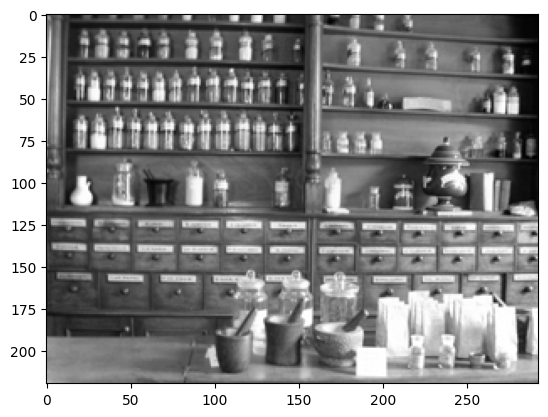

In [ ]:
#load images into lists
def load_images(directory):
    images = []
    img_class = []
    #there are 15 categories of pictures
    categories = [d for d in directory.iterdir()]
    #iterate categories and images and store images in a list in grayscale
    for i, categ in enumerate(categories):
        for file in categ.iterdir():
            img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
            images.append(img)
            img_class.append(i)

    return images, img_class

#path for training set
train_path = r'/content/drive/MyDrive/data/train'
train_dir = Path(train_path)

#path for testing set
test_path = r'/content/drive/MyDrive/data/test'
test_dir = Path(test_path)

#classes of categories
categories = [directory.name for directory in train_dir.iterdir()]
#number of classes/categories
n_classes = len(categories)

#load images and store them into arrays
train_img, Y_train = load_images(train_dir)
test_img, Y_test = load_images(test_dir)

#print the outcome
print("this is an example of a loaded image")
plt.imshow(train_img[0], cmap='gray')

**Q3 (1)**

a)

3. Classification Based on Feature Descriptor (episode 2) | continuation of Assignment 2/Q3... (45pts)

(1) Linear classifiers partition the feature space with a learned hyperplane and categorize test cases based on which side of that hyperplane they fall on. The final step is to train linear support vector machines (SVMs) in the bag of SIFT feature space.

a) Convert the problem into multiple-way classification and the classifier determines the test case's category by the most confident positive score "wins". (10pts)

In [ ]:
# compute sift with a 4 pixel-stride
def dense_sift(image_set):
    sift = cv2.xfeatures2d.SIFT_create()
    sift_features = []
    step_size = 20 #changed step size from 4 to 20 because the runtime took too long
    for img in tqdm(image_set):
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size)
                                            for y in range(0, img.shape[1], step_size)]
        kp, des = sift.compute(img, kp)
        sift_features.append(des)
    return sift_features

# extract sift features from training and testing images
X_train = dense_sift(train_img)
X_test = dense_sift(test_img)

#transform X_train into an np array
descriptors = []
for i in range(len(X_train)):
    for j in range(X_train[i].shape[0]):
        descriptors.append(X_train[i][j,:])
descriptors = np.array(descriptors)

In [ ]:
#create histogram based on the feature vocabulary
def histogram(image_set, kmeans, k):
    hist = []
    for img in tqdm(image_set):
        data = copy.deepcopy(img)
        pred = kmeans.predict(data)
        hist.append(np.bincount(pred, minlength=k).reshape(1,-1).ravel())
    return np.array(hist)

In [ ]:
#clustering
k=50
kmeans = KMeans(n_clusters=k).fit(descriptors)

#compute histograms for training images
train_hist = histogram(X_train, kmeans, k)
#fit scaler to train histogram
scaler = preprocessing.StandardScaler().fit(train_hist)
train_hist = scaler.transform(train_hist) #normalise histogram to zero mean and unit variance

#compute histograms for testing images
test_hist = histogram(X_test, kmeans, k)
test_hist = scaler.transform(test_hist) #normalise histogram to zero mean and unit variance

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 2995/2995 [00:01<00:00, 2752.41it/s]


In [ ]:
clf = LinearSVC(random_state=0, C=0.1, verbose=1)
clf.fit(train_hist, Y_train)
Y_pred = clf.predict(test_hist)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

[LibLinear]0.08280467445742905


b)

In [ ]:
#b) For a), add a validation set into your training procedure to adjust the learning parameters.
#This validation set can be either a portion of the training set or a subset of the test set that is not being used otherwise. (5pts)
#(Hints: the support vector machine does not need to be implemented and you may train different SVMs.)

**Q3 (2)**

In [ ]:
#(2) Attempt to enhance the nearest neighbor classifier so that it can match or surpass the performance of the linear SVM. (15pts)

**Q3 (3)**

In [ ]:
#(3) Based on the knowledge you learnt in the lecture and tutorial,
# can you design an algorithm or a model whose accuracy on testing dataset is better than 92%? (15pts)